In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

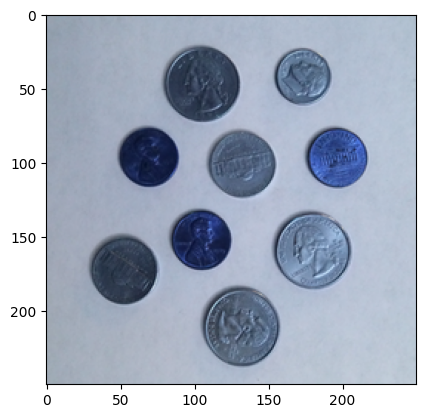

In [2]:
image = cv2.imread(r"C:\aiprojects\computer-vision\coins.png")
# cv2.imshow("Coins: ", image)
# cv2.waitKey(0)
plt.imshow(image)
plt.show()

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

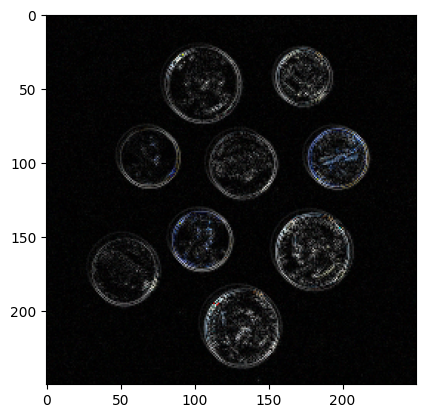

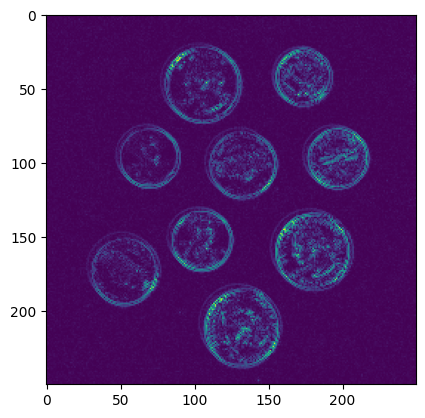

In [4]:
# Laplacian detects the change in pixel intensity by calculating ..
# ... second spatial derivative of an image
# step-1: convolution with kernel [[0,1,0],[1,-4,1],[0,1,0]]
# step-2: positive value in kernel = enhances edges by responding to intensity change
#         negative value in kernel = emphasize flat regions by responding to uniform intensity
# Blurring can be applied prior to improve the performance
# CV_64F = 64-bit floating point image because the output image can have +ve or -ve valuees.

# Trying with color image
lap = cv2.Laplacian(image, cv2.CV_64F)

# Laplacian gives positive or negative values in output. So, taking absolute values.
# Also converting in integer for visualization (pixels can have only integers values)
lap = np.uint8(np.absolute(lap))

# Laplacian with gray image
lap_gray = cv2.Laplacian(gray, cv2.CV_64F)
lap_gray = np.uint8(np.absolute(lap_gray))

plt.imshow(lap)
plt.show()

plt.imshow(lap_gray)
plt.show()

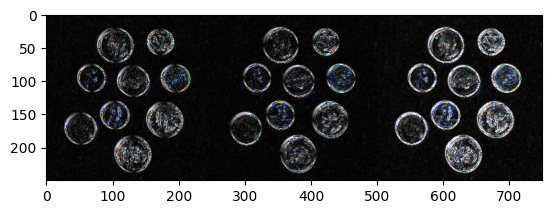

In [5]:
# Sobel calculates the gradient of pixel intensities to detect the change
# sobelX emphasize on vertical edges by computing horizontal gradient
# sobelY emphasize on horizontal edges by computing vertical gradient

sobelX = cv2.Sobel(image, cv2.CV_64F, 1, 0)
sobelY = cv2.Sobel(image, cv2.CV_64F, 0, 1)

sobelX = np.uint8(np.absolute(sobelX))
sobelY = np.uint8(np.absolute(sobelY))

sobelCombined = cv2.bitwise_or(sobelX, sobelY)

# cv2.imshow("Sobel X", sobelX)
# cv2.imshow("Sobel Y", sobelY)
# cv2.imshow("Sobel Combined", sobelCombined)
# cv2.waitKey(0)
plt.imshow(np.hstack([sobelX, sobelY, sobelCombined]))
plt.show()

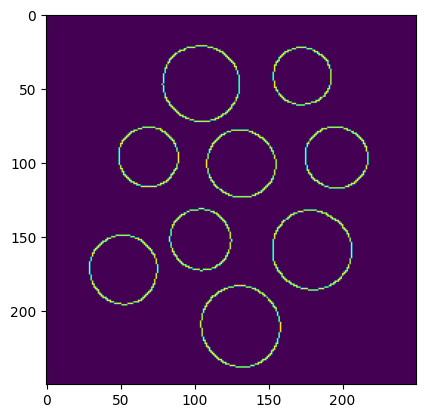

In [6]:
# Canny edge detection (multi-stage)
# convert to grayscale >> blur the image >> calculate gradient ...
# ... >> non-maximum suppression (take only maximum gradient - highest difference in intensity within minima) ...
# ... >> double-thresholding (divides the image into 3 parts: strong edges (px > T_High)... 
# ... weak edges (T_Low < px < T_High), no edges (px < T_Low)) ...
# ... >> edge tracking by hysteresis: Weak edges that are connected to strong edges ...
# ... are kept, while isolated weak edges are suppressed...
# ... Starting from strong edge pixels, the algorithm follows connected weak edges ...
# ... and considers them as part of the final edge map.

blurred = cv2.GaussianBlur(gray, (9,9), 0)

# canny = cv2.Canny(image, T_Low, T_High)
canny = cv2.Canny(blurred, 30, 150)

plt.imshow(canny)
plt.show()

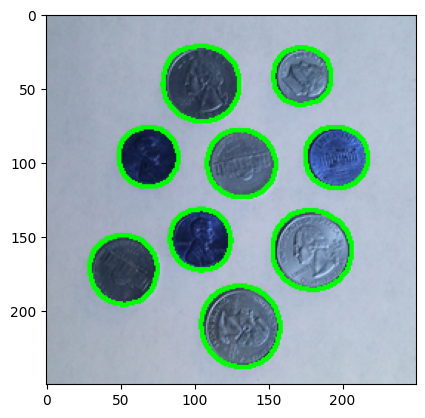

In [7]:
# Find contours
# Create a copy to avoid modifying original image
# cv2.RETR_EXTERNAL retrieves only the extreme outer contours...
# ... It ignores contours inside other contours. This is often useful when you are...
# ... only interested in the contours of the outermost objects in an image.

# cv2.CHAIN_APPROX_SIMPLE compresses horizontal, diagonal, and vertical segments and leaves ...
# ... only their end points. For example, if a contour is a straight line, it is ...
# ... compressed to only two end points. This reduces memory usage and speeds up ...
# ...processing. It is a good choice when you don't need all the points along the contour.

# cnts is the list of the contours detected (list of points)
# _ is the place holder for hierarchy if there are nested contours.

(cnts, _) = cv2.findContours(canny.copy(), 
                             cv2.RETR_EXTERNAL, 
                             cv2 .CHAIN_APPROX_SIMPLE
)

coins = image.copy()

# Draw the contours with green colors
# -1 is for all contours
# 2 is the thickness of the contour

cv2.drawContours(coins, cnts, -1, (0, 255, 0), 2)
plt.imshow(coins)
plt.show()

In [8]:
# Count the contours
print("Number of coins: ", len(cnts))

Number of coins:  9


Watershed Algorithm - Overlapping Objects

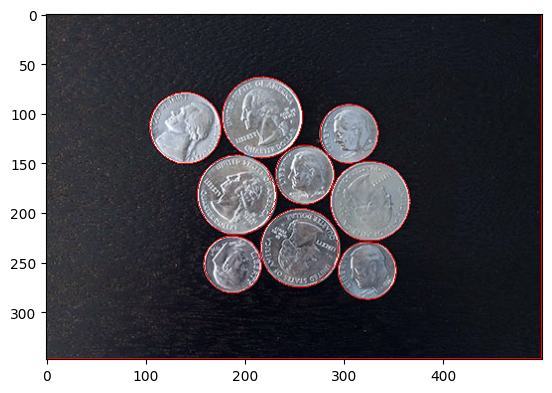

In [88]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


# Watershed documentation

coins_overlap = cv2.imread(r"C:\aiprojects\computer-vision\coins_overlap.jpg")
assert coins_overlap is not None, "file could not be read, check with os.path.exists()"

gray = cv2.cvtColor(coins_overlap,cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (19, 19), 0)


#Threshold Processing 
ret, bin_img = cv2.threshold(blurred, 
                             0, 255,  
                             cv2.THRESH_OTSU) 

# Noise Removal

# Morphological Operations: On shapes and structures
# Erosion - shrinks the boundaries - for removing small isolated structures
# Dilation - expands the boundaries - for filling gaps, joining structures
# Opening = Erosion >> Dilation - First remove small structures and then seperate objects
# Closing = Dilation >> Erosion - Used to close the gaps between nearby objects

# Increasing iterations will increase the overall effect of OPENING

# kernel is the 3x3 matrix that gets convoluted on the image to get the desired effect

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)) 
bin_img = cv2.morphologyEx(bin_img,  
                           cv2.MORPH_OPEN, 
                           kernel, 
                           iterations=3) 

# cv2.imshow("Binary Image", np.hstack([gray, bin_img]))
# cv2.waitKey(0)

# Enhancing the background by dilating the shape boundaries
sure_bg = cv2.dilate(bin_img,kernel,iterations=3)

# Finding the pixel values representing Euclidean distance of each foreground pixel ...
# ... from the nearest background pixel
# bin_img should be with black background and white foreground
# cv2.DIST_L2 = Euclidean distance metrix (sqrt((x2 - x1)^2 + (y2 - y1)^2))
# Last value (0) - kernel size - defines the neighbourhood within which the distanc is calculated.
# Reducing kernel size = can detect more detailed and smaller structures
# Increaseing kernel size = less sensitive to smaller structure detection.
# kernel size can be 0 / 3/ 5

dist_transform = cv2.distanceTransform(bin_img,cv2.DIST_L2,0)

# ret returns the threshold value
# pixel values below thresholding value (0.7 * max distance) is 0
# This will enhance the foreground objects and save in sure_fg
# 0.7 is empirical value and can change according to the application
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Converting into integer matrix
sure_fg = np.uint8(sure_fg)

# Unknown area represents the area where the algorithm is uncertain if it is ...
# ... a foreground or background
# Giving this area in the marker will tell the watershed algorithm to carefully decide in these regions.
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
# It assigns a label to each connected components
# ret >> number of connected components (In this case it should be 9 (9 coins))
# markers >> labeled image where each pixel is assigned a label that corresponds to connected component.
ret, markers = cv2.connectedComponents(bin_img)

# Add one to all labels so that sure background is not 0, but 1 because indexing starts from 0
markers = markers+1
# Now, mark the region of unknown with zero so unknown regions become the part of background.
markers[unknown==255] = 0

# Apply the watershed algorithm to the original image with the markers
markers = cv2.watershed(coins_overlap,markers)

# Rewriting the coin_overlap by changing pixel values at boundaries with a color
# markers == -1 is for boundaries.
coins_overlap[markers == -1] = [255,0,0]

# cv2.imshow("Object Segmentation", coins_overlap)
# cv2.waitKey(0)
coins_overlap_with_markers = coins_overlap
plt.imshow(coins_overlap_with_markers, cmap='gray')

Number of Contours:  14


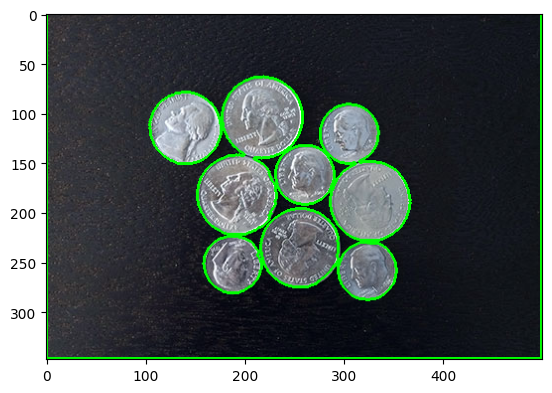

In [95]:
coins_overlap_copy = coins_overlap.copy()
markers1 = markers.astype(np.uint8)
ret, m2 = cv2.threshold(markers1, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(m2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE) 
print("Number of Contours: ", len(contours))

for c in contours:
    cv2.drawContours(coins_overlap_copy, c, -1, (0, 255, 0), 2)
plt.imshow(coins_overlap_copy, cmap='gray')

# Here the algorithm is not counting exact number of contours because some contours are...
# ...connected. We can change few parameters to improve the results.

Shape Detection

In [96]:
image = cv2.imread(r"C:\aiprojects\computer-vision\Shapes.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
edged = cv2.Canny(blurred, 30, 150)

# cv2.imshow("Shapes_Interim", np.hstack([gray, blurred, edged]))
# cv2.waitKey(0)

In [97]:
(cnts, _) = cv2.findContours(edged.copy(), 
                             cv2.RETR_EXTERNAL, 
                             cv2 .CHAIN_APPROX_SIMPLE
)

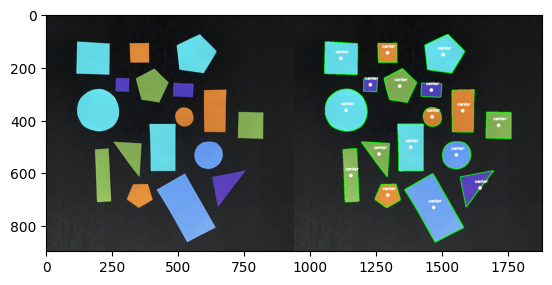

In [105]:
# Moments are a set of parameters used to describe the spatial distribution...
# ... of intensity in an image.
# For a contour, moments provide information about its area, ...
# ...centroid, orientation, and other properties.
# M["m10"]: The moment of the contour with respect to the x-axis.
# M["m01"]: The moment of the contour with respect to the y-axis.
# M["m00"]: The zeroth order moment, which is essentially the area of the contour.

for c in cnts:
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    # Draw the boundaries around the shapes
    cv2.drawContours(shapes, [c], -1, (0, 255, 0), 2)

    # Draw a small circle at the center of any shape
    cv2.circle(shapes, (cX, cY), 7, (255, 255, 255), -1)

    # Write a small text "center" near the circle showing the center
    # cv2.FONT_HERSHEY_SIMPLEX = Font style
    # 0.5 = Font scale
    # 2 = Thickness
    cv2.putText(shapes, 
                "center", 
                (cX - 20, cY - 20),
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.5, 
                (255, 255, 255), 
                2
    )
    
    plt.imshow(np.hstack([image, shapes]))

    # It is giving one wrong center for lower right triangle

In [106]:
class ShapeDetector:
    def __init__(self):
        pass
    
    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"

        # Calculates the perimeter of the contour
        peri = cv2.arcLength(c, True)

        # Approximate the contour with a polygon
        # 0.04 * peri is epsilon value controlling the approximation accuracy
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        
        if len(approx) == 3:
            shape = "triangle"
        elif len(approx) == 4:
            # This can be square or rectangle
            # compute the bounding box of the contour & use the bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
            
            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
            
        elif len(approx) == 5:
            shape = "pentagon"
        else:
            shape = "circle"
        
        return shape

sd = ShapeDetector()

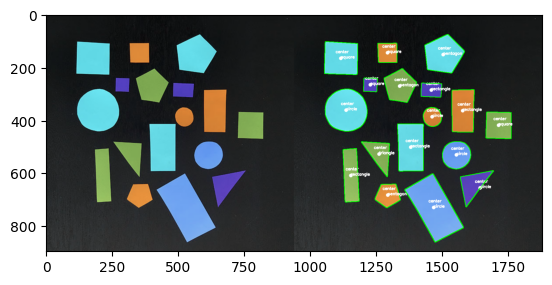

In [107]:
# Detecting the shapes and labelling them

for c in cnts:
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    shape = sd.detect(c)
    
    cv2.drawContours(shapes, [c], -1, (0, 255, 0), 2)
    cv2.putText(shapes, 
                shape, 
                (cX, cY),
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.5, 
                (255, 255, 255), 
                2
    )
    
    plt.imshow(np.hstack([image, shapes]))